In [1]:
import boto3
import json
import boto3
import re
import csv
import sagemaker
from sagemaker import get_execution_role
from sagemaker.s3 import S3Uploader, S3Downloader
import uuid
import time
import io
from io import BytesIO
import sys
from pprint import pprint

from IPython.display import Image, display
from PIL import Image as PImage, ImageDraw

In [2]:
!pip install amazon-textract-response-parser

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
role = get_execution_role()
#print("RoleArn: {}".format(role))

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'claims-process-textract'

### Benefit Enrollment

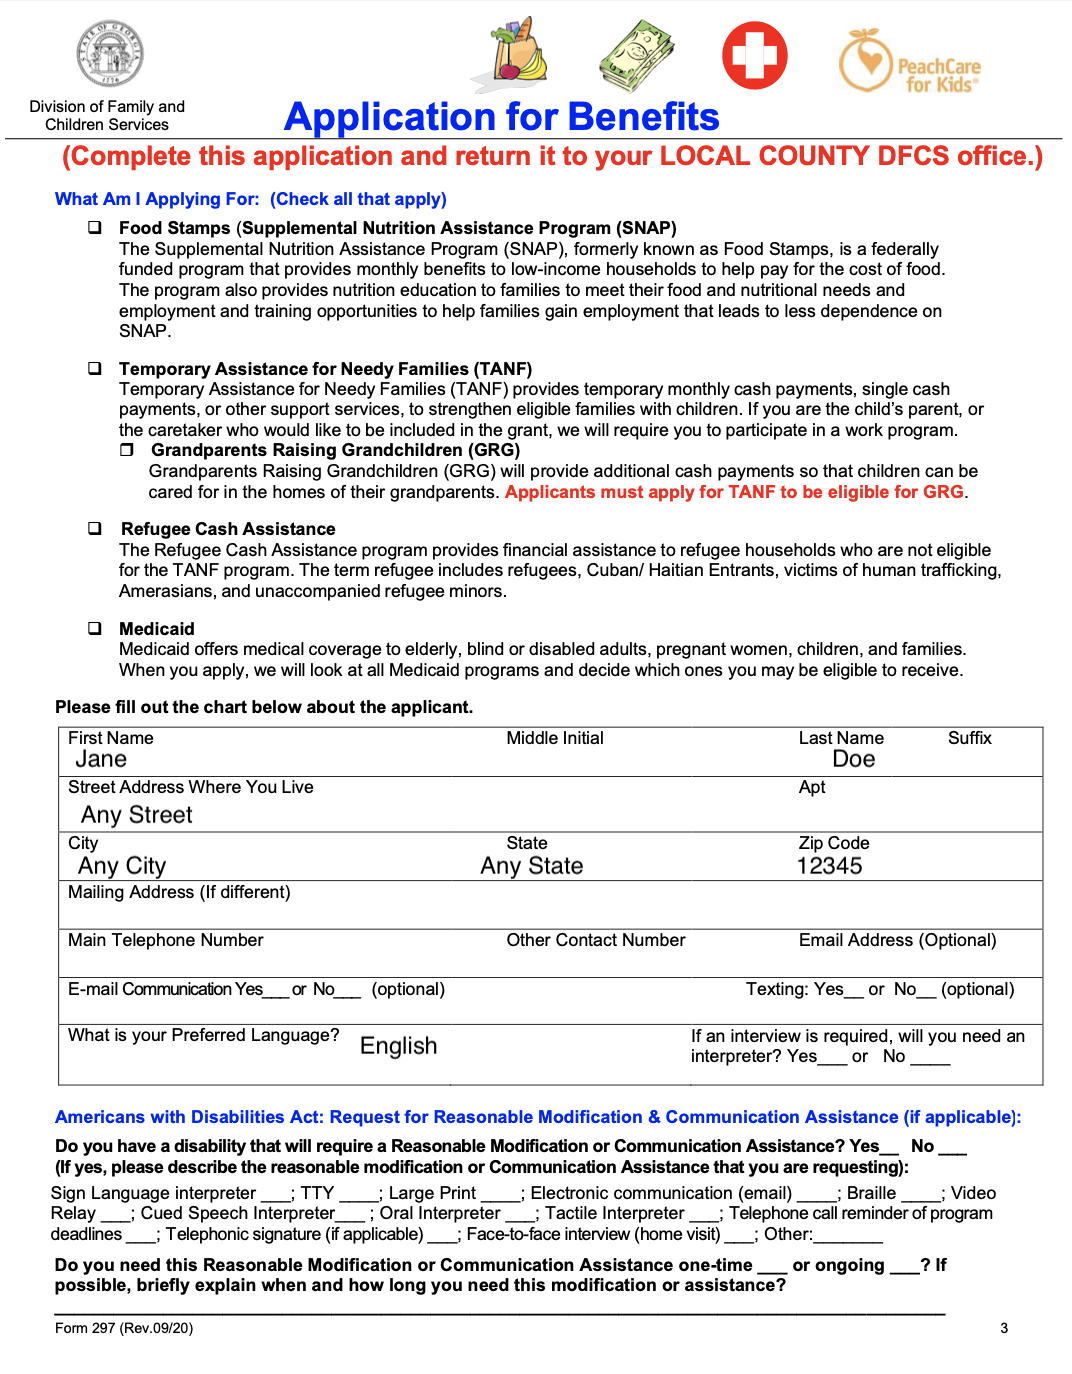

In [4]:
# Document

documentName = "benefit-app.png"

display(Image(filename=documentName))

In [5]:
client = boto3.client(service_name='textract',
         region_name= 'us-east-1',
         endpoint_url='https://textract.us-east-1.amazonaws.com')
# process using image bytes
def calltextract(documentName): 

    with open(documentName, 'rb') as file:
            img_test = file.read()
            bytes_test = bytearray(img_test)
            print('Image loaded', documentName)

    # process using image bytes
    response = client.analyze_document(Document={'Bytes': bytes_test}, FeatureTypes=['FORMS'])

    return response

In [6]:
response= calltextract(documentName)
print(response)

Image loaded benefit-app.png
{'DocumentMetadata': {'Pages': 1}, 'Blocks': [{'BlockType': 'PAGE', 'Geometry': {'BoundingBox': {'Width': 1.0, 'Height': 1.0, 'Left': 0.0, 'Top': 0.0}, 'Polygon': [{'X': 0.0, 'Y': 0.0}, {'X': 1.0, 'Y': 5.554137771923706e-08}, {'X': 1.0, 'Y': 1.0}, {'X': 2.208991958241313e-07, 'Y': 1.0}]}, 'Id': '648062c6-26cc-4fde-8a66-d7225ee3873b', 'Relationships': [{'Type': 'CHILD', 'Ids': ['e333047b-43fe-4848-91d9-47a1665ee344', 'd6d10f76-c1da-4a87-a0ac-020aea3370fc', '223718f0-d851-4160-9f8a-73a9577e9f45', 'c6cf0b1b-3026-4d63-aa9e-de50c06f658e', '1f684bbd-6f2f-4354-9e4d-df0b6429ec2b', 'bbf314ef-bd1f-4cb2-b779-6a4aa24223fb', '56f14f45-4b29-40ac-9ac5-f927e2cbe0ca', '8ac792e9-5548-45e7-ae4e-60519972d96e', '65f9bae1-7776-449e-a0d4-69db4a919ffe', '5b6ae647-213c-44e3-abac-99a3af8f2a12', '3a536f28-8884-4ece-972b-31aa5f9c21f8', '8387f64b-f3cc-4465-9054-7c11e3eb898d', '0c7a8991-2b25-4ae5-ae54-10885d350be3', '490df01c-afac-4286-b267-d73a4671a99c', '93665391-610a-4fba-8c0f-27979d

In [7]:
#Extract key values
# Iterate over elements in the document
from trp import Document
def getformkeyvalue(response):
    doc = Document(response)
    
    key_map = {}
    for page in doc.pages:
        # Print fields
        for field in page.form.fields:
            if field is None or field.key is None or field.value is None:
                continue
        
            key_map[field.key.text] = field.value.text
    return key_map

In [18]:
get_form_keys = getformkeyvalue(response)
print(get_form_keys)

{'City': 'Any City', 'First Name': 'Jane', 'Zip Code': '12345', 'Street Address Where You Live': 'Any Street', 'State': 'Any State', 'Braille': ';', 'What is your Preferred Language?': 'English', 'Yes': 'NOT_SELECTED', 'Food Stamps (Supplemental Nutrition Assistance Program (SNAP) The Supplemental Nutrition Assistance Program (SNAP), formerly known as Food Stamps, is a federally funded program that provides monthly benefits to low-income households to help pay for the cost of food. The program also provides nutrition education to families to meet their food and nutritional needs and employment and training opportunities to help families gain employment that leads to less dependence SNAP.': 'NOT_SELECTED', 'Refugee Cash Assistance The Refugee Cash Assistance program provides financial assistance to refugee households who are not eligible for the TANF program. The term refugee includes refugees, Cuban/Haitian Entrants, victims of human trafficking, Amerasians, and unaccompanied refugee m

In [8]:
response = None
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

    # Call Textract
    response = client.analyze_document(
        Document={'Bytes': imageBytes},
        # new QUERIES Feature Type for Textract Queries
        # We could add additional Feature Types like FORMS and/or TABLES
        # FeatureTypes=["QUERIES", "FORMS", "TABLS"],
        FeatureTypes=["QUERIES"],
        QueriesConfig={
            "Queries": [{
                "Text": "What is the prefered language?",
                "Alias": "LANGUAGE"
            }
        ]
        })
    print(response)

{'DocumentMetadata': {'Pages': 1}, 'Blocks': [{'BlockType': 'PAGE', 'Geometry': {'BoundingBox': {'Width': 1.0, 'Height': 1.0, 'Left': 0.0, 'Top': 0.0}, 'Polygon': [{'X': 0.0, 'Y': 0.0}, {'X': 1.0, 'Y': 5.554137771923706e-08}, {'X': 1.0, 'Y': 1.0}, {'X': 2.208991958241313e-07, 'Y': 1.0}]}, 'Id': 'ea17f746-5475-4b00-bd2c-fcc011f85ff5', 'Relationships': [{'Type': 'CHILD', 'Ids': ['329e8856-04c6-4e04-95a0-2b826d001427', 'aadcd56f-3e02-4bca-9cfa-85c6147cc066', 'c1c3dc3b-cef2-495e-ac4e-dbb840a1a867', '635e16ca-8ef5-49ba-b804-1bb5c00d5671', 'a0b81521-5bab-4d64-aa6e-6793d4375595', '085cf716-9798-411f-af92-bf5eea5e7fc7', '43651ee3-7f2b-4f73-b90c-cab11d1bcda4', '2515672b-7546-484a-ac2f-88d26f158c7b', 'fdca49bd-b763-411a-a8bb-ec9a62b224c9', '2d9b6a4e-90c4-432b-a9e0-142d04f991a5', '4589e8ea-44c8-4d61-a27d-7a0e0feb9eb9', 'eda89768-e97a-451e-847a-35fd61d77d49', '5975fd12-a29c-44e3-9dfb-199754e4aa6a', '4e80693d-c033-4a1f-a7a7-2e18b02343d1', '6574d202-b7ac-4628-976e-ec0b2c72d716', '94493f82-ef72-48a2-

#### SSN Document

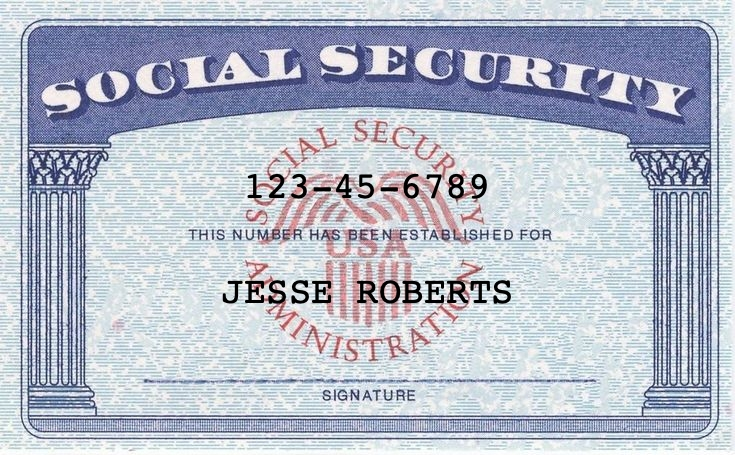

In [10]:
# Document

documentName = "ssn_Jesse_123456789.jpg"

display(Image(filename=documentName))

In [11]:
response = None
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

    # Call Textract
    response = client.analyze_document(
        Document={'Bytes': imageBytes},
        # new QUERIES Feature Type for Textract Queries
        # We could add additional Feature Types like FORMS and/or TABLES
        # FeatureTypes=["QUERIES", "FORMS", "TABLS"],
        FeatureTypes=["QUERIES"],
        QueriesConfig={
            "Queries": [{
                "Text": "What is the ssn number?",
                "Alias": "SSN"
            },
            {
                "Text": "What is the name?",
                "Alias": "NAME"
            }
                
        ]
        })
    print(response)

{'DocumentMetadata': {'Pages': 1}, 'Blocks': [{'BlockType': 'PAGE', 'Geometry': {'BoundingBox': {'Width': 1.0, 'Height': 0.9873040318489075, 'Left': 0.0, 'Top': 0.012695963494479656}, 'Polygon': [{'X': 0.0013104579411447048, 'Y': 0.012695963494479656}, {'X': 0.998745322227478, 'Y': 0.023070551455020905}, {'X': 1.0, 'Y': 1.0}, {'X': 0.0, 'Y': 1.0}]}, 'Id': 'c49073a4-90d2-4239-8517-54162617e1bb', 'Relationships': [{'Type': 'CHILD', 'Ids': ['18301154-1d41-43d9-8356-512c4145f69c', '7e9e0b37-da0f-4dc9-ae01-3e6c1c4e32a3', '37d54ffa-2d9b-409d-b8c3-d8026e40cbf5', '23ac9ffc-a46e-4321-b70f-1d99d9846a28', 'f9080a78-b6f3-42b3-be1b-1302d7a41729', '0ddb1eca-bcc8-4d5f-bce8-98a2cd108fb7', '369d9aa7-566e-4a06-82ba-03d826343f76', '89f3dcd7-4e95-40ab-a98f-8681b39254d9', '13364ed1-c428-4923-82dc-14515c577ba2', '4fad627f-0d69-4f8e-80fe-3da59d49d07e', '2e652661-181a-4d57-b315-67f9a91739ba', '0bbd2924-051b-4dba-9d46-86d6510c5a10', '9f19ffe1-3e5b-46d4-8c1c-e8670a0611e5', '6d6d1f8e-8481-4b2d-a3b7-05c9d207e5d9'

### Claims Processing

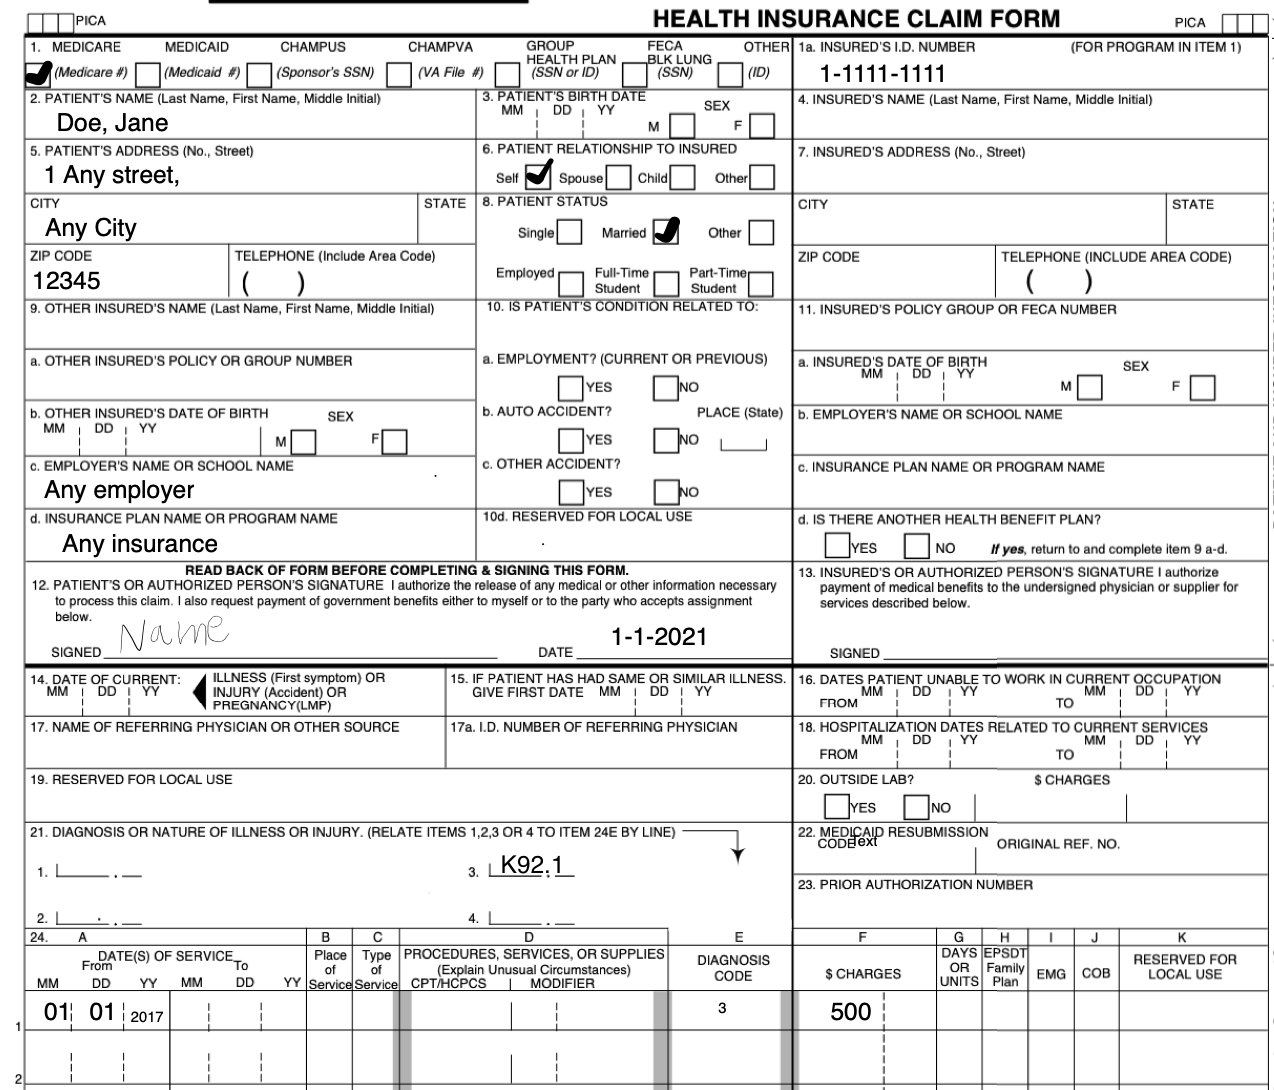

In [12]:
# Document

documentName = "cms1500-1.png"

display(Image(filename=documentName))

# Sample Document

30 fields. 2 fileds are optional [ local use, xxx]
member id field is a mandatory field

# Data Extraction

In [13]:
# process using image bytes
def calltextract(documentName): 
    client = boto3.client(service_name='textract',
         region_name= 'us-east-1',
         endpoint_url='https://textract.us-east-1.amazonaws.com')

    with open(documentName, 'rb') as file:
            img_test = file.read()
            bytes_test = bytearray(img_test)
            print('Image loaded', documentName)

    # process using image bytes
    response = client.analyze_document(Document={'Bytes': bytes_test}, FeatureTypes=['FORMS'])

    return response

In [14]:
response= calltextract(documentName)
print(response)

Image loaded cms1500-1.png
{'DocumentMetadata': {'Pages': 1}, 'Blocks': [{'BlockType': 'PAGE', 'Geometry': {'BoundingBox': {'Width': 1.0, 'Height': 1.0, 'Left': 0.0, 'Top': 0.0}, 'Polygon': [{'X': 3.1591906690664473e-07, 'Y': 0.0}, {'X': 1.0, 'Y': 4.2800297705980483e-07}, {'X': 1.0, 'Y': 1.0}, {'X': 0.0, 'Y': 1.0}]}, 'Id': '2d9c714d-28b7-468d-bdb8-b21946f66221', 'Relationships': [{'Type': 'CHILD', 'Ids': ['67a6015e-b916-4322-afbd-3da800baeee7', 'a7a50e89-736f-4eae-ba3f-8ce311db89c0', '60ceb824-670b-44fb-aa08-e690f32adb60', '1763221c-8235-4fd3-936d-36fd44866c38', 'b2fe1f6d-216d-4705-9792-c494dcac47f5', 'cbf602dd-9b9c-4ac2-9180-a5eaa8053dc6', '52dc220c-6cb6-4935-9e13-d3bbfa4562a3', 'daf446d0-2af0-465e-8241-f5ca136156d0', '24be4de1-7784-486a-9634-bd464935ebc0', '1422fc44-498e-42ce-9415-ab65b14b6775', '0a67b8fd-6d54-4d4c-a00a-0d4835ed7d89', 'fccf1fee-3757-4f95-9fc6-bc8ed68dca85', '1ffc62fc-677d-41f7-b261-c3d0d88a2afd', '09e6ab9a-6159-432e-86c3-66f88fd0236e', '7b1f933f-0aff-4200-bfb7-558ebb

In [15]:
#Extract key values
# Iterate over elements in the document
from trp import Document
def getformkeyvalue(response):
    doc = Document(response)
    
    key_map = {}
    for page in doc.pages:
        # Print fields
        for field in page.form.fields:
            if field is None or field.key is None or field.value is None:
                continue
        
            key_map[field.key.text] = field.value.text
    return key_map

In [16]:
get_form_keys = getformkeyvalue(response)
print(get_form_keys)

{'ZIP CODE': '12345', '(ID)': 'NOT_SELECTED', 'NO': 'NOT_SELECTED', 'TELEPHONE (Include Area Code)': '( )', 'Single': 'NOT_SELECTED', 'CITY': 'Any City', 'Employed': 'NOT_SELECTED', 'Self': 'SELECTED', 'YES': 'NOT_SELECTED', 'Full-Time Student': 'NOT_SELECTED', 'Other': 'NOT_SELECTED', 'Married': 'SELECTED', 'DATE': '1-1-2021', "2. PATIENT'S NAME (Last Name, First Name, Middle Initial)": 'Doe, Jane', 'FECA BLK LUNG (SSN)': 'NOT_SELECTED', "5. PATIENT'S ADDRESS (No., Street)": '1 Any street,', 'd. INSURANCE PLAN NAME OR PROGRAM NAME': 'Any insurance', "c. EMPLOYER'S NAME OR SCHOOL NAME": 'Any employer', 'TELEPHONE (INCLUDE AREA CODE)': '( )', 'SIGNED': 'Name', 'F': 'NOT_SELECTED', 'M': 'NOT_SELECTED', 'Part-Time Student': 'NOT_SELECTED', '3.': 'K92.1', 'Child': 'NOT_SELECTED', '(Medicare #)': 'SELECTED', "CHAMPUS (Sponsor's SSN)": 'NOT_SELECTED', "1a. INSURED'S I.D. NUMBER (FOR PROGRAM IN ITEM 1)": '1-1111-1111', 'CHAMPVA': 'NOT_SELECTED', 'PICA': 'NOT_SELECTED', 'MEDICAID': 'NOT_SELECT

# Post processing - Check for completeness - Acceptance Process
Check for validation using business rules for all the details in the claims document is present.
Checking if claim Id is 12 digit and zip code is digit

Adjudication - checking for code
participation, expectation rule - prior auth details is present
Evaluation - patient benefits and provider details for what is covered
Determination - payment, partial, denial

In [20]:
def validate(body):
    json_acceptable_string = body.replace("'", "\"")
    
    json_data = json.loads(body)
    
    zip = json_data['ZIP CODE']
    
    id = json_data['1a. INSURED\'S I.D. NUMBER (FOR PROGRAM IN ITEM 1)']
    
    diagnosiscode = json_data["3."]
    print(diagnosiscode)
    print(id)
    print(zip)
    if(not zip.strip().isdigit()):
        return False, id, diagnosiscode, "Zip code invalid"
    length = len(id.strip())
    if(length != 11):
        return False, id, diagnosiscode, "Invalid claim Id"
    return True, id, diagnosiscode, "Ok"

In [21]:
 # Validate 
textract_json= json.dumps(get_form_keys,indent=2)
res, formid, diagnosiscode, result = validate(textract_json)
print(result)
print(formid)

K92.1
1-1111-1111
12345
Ok
1-1111-1111


# Enrich with medical insights
Valid Medical Intake Form send to Comprehend medical to gain insights

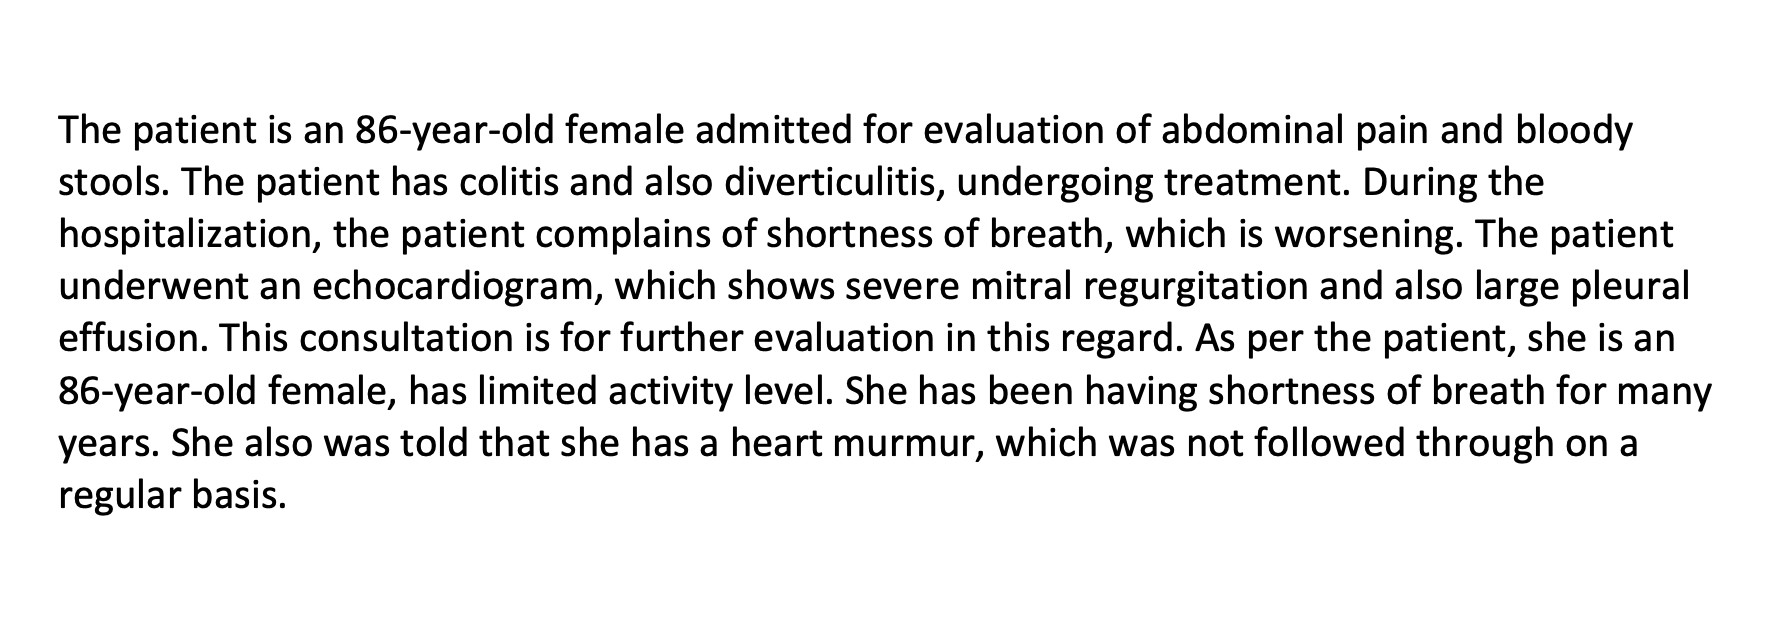

In [23]:
documentName = "doctornotes1.png"
display(Image(filename=documentName))



In [24]:
response= calltextract(documentName)
# Print text
print("\nText\n========")
text = ""
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        print ('\033[94m' +  item["Text"] + '\033[0m')
        text = text + " " + item["Text"]

Image loaded doctornotes1.png

Text
The patient is an 86-year-old female admitted for evaluation of abdominal pain and bloody
stools. The patient has colitis and also diverticulitis, undergoing treatment. During the
hospitalization, the patient complains of shortness of breath, which is worsening. The patient
underwent an echocardiogram, which shows severe mitral regurgitation and also large pleural
effusion. This consultation is for further evaluation in this regard. As per the patient, she is an
86-year-old female, has limited activity level. She has been having shortness of breath for many
years. She also was told that she has a heart murmur, which was not followed through on a
regular basis.



## Get Medical Insights

In [25]:
comprehend = boto3.client(service_name='comprehendmedical')
# Detect medical entities

cm_json_data =  comprehend.detect_entities_v2(Text=text)

print("\nMedical Entities\n========")
for entity in cm_json_data["Entities"]:
    print("- {}".format(entity["Text"]))
    print ("   Type: {}".format(entity["Type"]))
    print ("   Category: {}".format(entity["Category"]))
    if(entity["Traits"]):
        print("   Traits:")
        for trait in entity["Traits"]:
            print ("    - {}".format(trait["Name"]))
    print("\n")


Medical Entities
- 86
   Type: AGE
   Category: PROTECTED_HEALTH_INFORMATION


- evaluation
   Type: TEST_NAME
   Category: TEST_TREATMENT_PROCEDURE


- abdominal
   Type: SYSTEM_ORGAN_SITE
   Category: ANATOMY


- pain
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - SYMPTOM


- bloody stools
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - SYMPTOM


- colitis
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - DIAGNOSIS


- diverticulitis
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - DIAGNOSIS


- treatment
   Type: TREATMENT_NAME
   Category: TEST_TREATMENT_PROCEDURE


- shortness of breath
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - SYMPTOM


- echocardiogram
   Type: TEST_NAME
   Category: TEST_TREATMENT_PROCEDURE


- mitral
   Type: SYSTEM_ORGAN_SITE
   Category: ANATOMY


- mitral regurgitation
   Type: DX_NAME
   Category: MEDICAL_CONDITION


- pleural
   Type: SYSTEM_ORGAN_SITE
   Category: A

In [27]:
cm_json_data =  comprehend.infer_icd10_cm(Text=text)

print("\n Medical coding\n========")
code = []
for entity in cm_json_data["Entities"]:
    
    for icd in entity["ICD10CMConcepts"]:
        
        if (icd["Score"] >= 0.90):
            code.append(icd["Code"])
print(code)
            



 Medical coding
['K92.1', 'R06.02', 'J90', 'R06.02', 'R01.1']


## Post Processing - Compare the dignosis code from the RAW doctor's notes

In [28]:
print("diagnosis code from claim form", diagnosiscode)
print("diagnosis code from raw doctor's note", code)

diagnosis code from claim form K92.1
diagnosis code from raw doctor's note ['K92.1', 'R06.02', 'J90', 'R06.02', 'R01.1']


# Invalid Claim

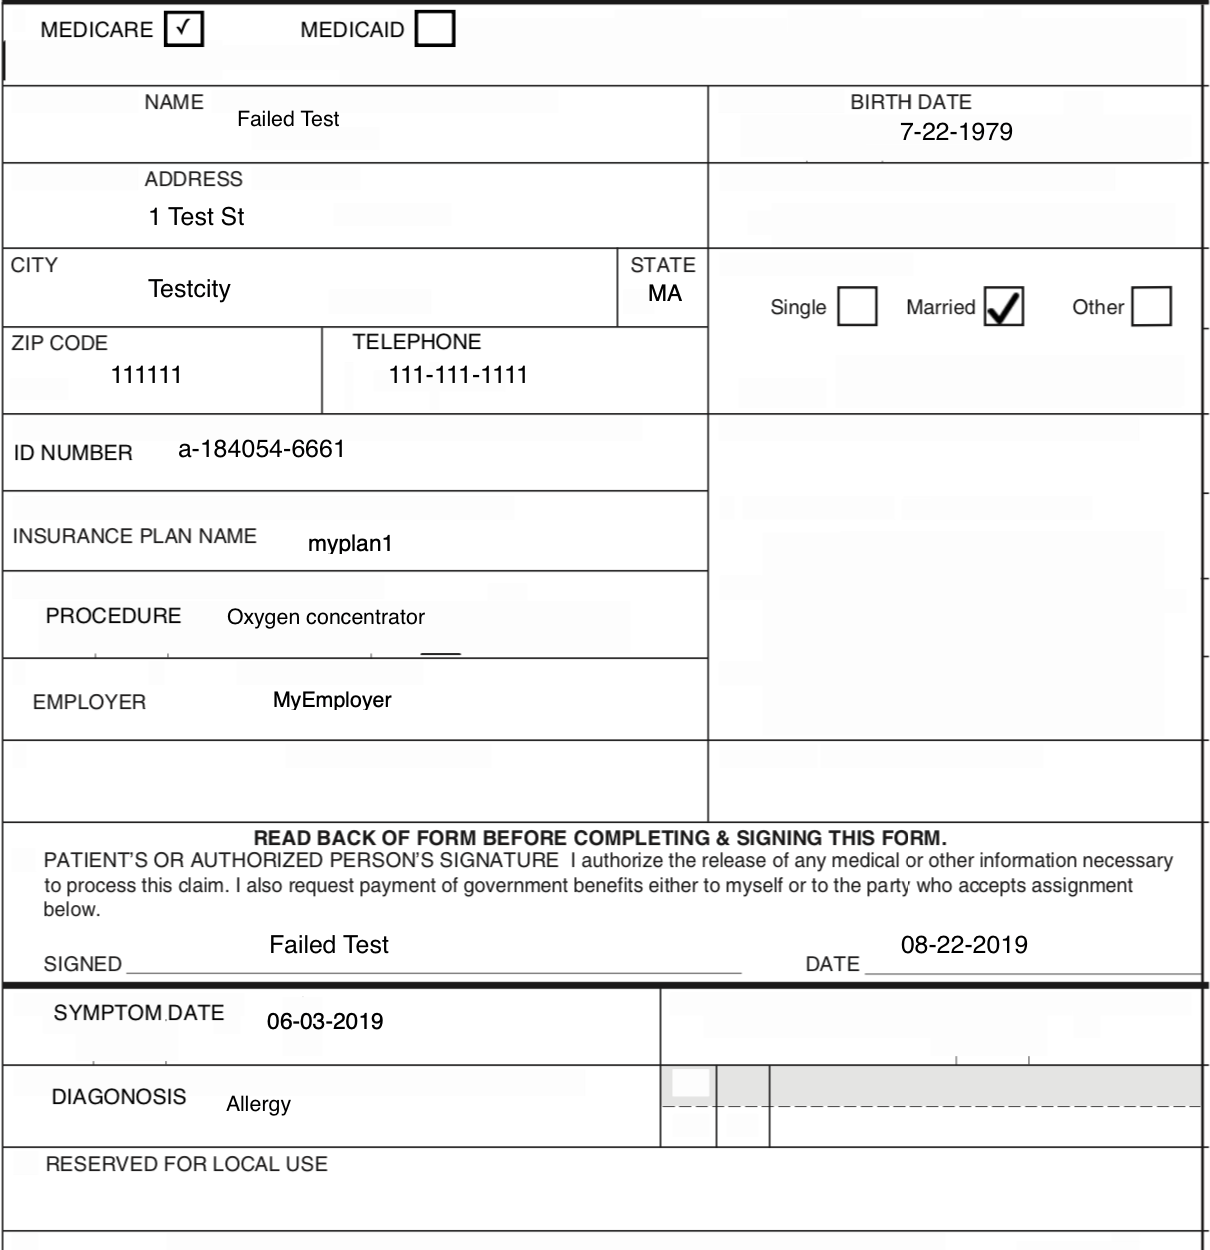

In [30]:
InvalidDocument = "failedtest.png"

display(Image(filename=InvalidDocument))

In [31]:
response = calltextract(InvalidDocument)

Image loaded failedtest.png


In [32]:
get_form_keys = getformkeyvalue(response)
print(get_form_keys)

{'CITY': 'Testcity', 'TELEPHONE': '111-111-1111', 'DATE': '08-22-2019', 'ADDRESS': '1 Test St', 'Married': 'SELECTED', 'ZIP CODE': '111111', 'Other': 'NOT_SELECTED', 'SIGNED': 'Failed Test', 'NAME': 'Failed Test', 'MEDICAID': 'NOT_SELECTED', 'ID NUMBER': 'a-184054-6661', 'INSURANCE PLAN NAME': 'myplan1', 'BIRTH DATE': '7-22-1979', 'MEDICARE': 'SELECTED', 'SYMPTOM.DATE': '06-03-2019', 'Single': 'NOT_SELECTED', 'EMPLOYER': 'MyEmployer', 'STATE': 'MA', 'PROCEDURE': 'Oxygen concentrator', 'DIAGONOSIS': 'Allergy'}


In [33]:
 #In Validate 
textract_json= json.dumps(get_form_keys,indent=2)
json_data = json.loads(textract_json)

id = json_data['ID NUMBER']
print(id)

length = len(id.strip())
if(length != 11):
    print("Invalid claim Id")


a-184054-6661
Invalid claim Id


Delete the Amazon s3 bucket and the files in the buckethttps://docs.aws.amazon.com/AmazonS3/latest/userguide/delete-bucket.html